In [19]:
%pip install --quiet --upgrade matplotlib tqdm
%pip install --quiet --editable energyplus-extras matplotlib-extras

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [20]:
%matplotlib widget

import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

In [21]:
import matplotlib_extras as mplx
import matplotlib_extras.animation
import matplotlib_extras.lines

In [22]:
import ooep
import ooep.utils
import ooep.ems

In [23]:
env = ooep.ems.Environment().__enter__()

In [24]:
tmeter = env.variable(dict(
    variable_name='People Air Temperature',
    variable_key='CORE_MID'
))

tstat_cool = env.actuator(dict(
    component_type='Zone Temperature Control',
    control_type='Cooling Setpoint',
    actuator_key='CORE_MID'
))

tstat_heat = env.actuator(dict(
    component_type='Zone Temperature Control',
    control_type='Heating Setpoint',
    actuator_key='CORE_MID'
))

emeter = env.meter(dict(
    meter_name='Electricity:Zone:CORE_MID'
))

timestep = 0

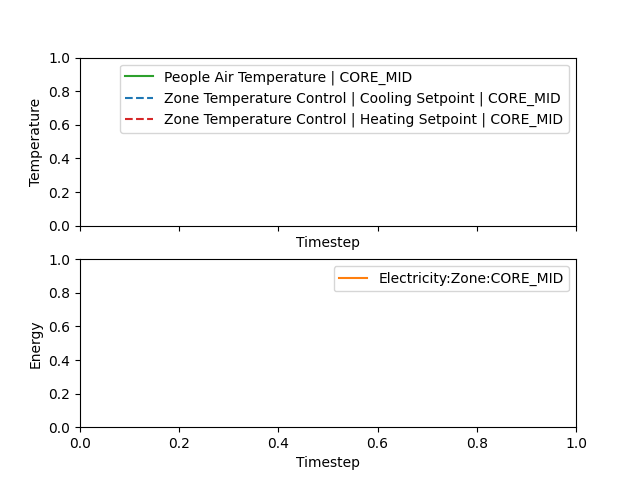

In [25]:
FigureAnimation = mplx.animation.FigureAnimation
StepFunction2D = mplx.lines.StepFunction2D

fig, (ax_temp, ax_elec) = plt.subplots(nrows=2, sharex=True)

# TODO AnimatedFigure: add artists automatically
animation = FigureAnimation(
    fig,
    [
        # temperatures
        ax_temp.add_artist(
            StepFunction2D(
                lambda: (timestep, tmeter.value),
                label=tmeter.name,
                linestyle='-',
                color='tab:green'
            )
            .autofit()
        ),
        ax_temp.add_artist(
            StepFunction2D(
                lambda: (timestep, tstat_cool.value),
                label=tstat_cool.name,
                linestyle='--',
                color='tab:blue'
            )
            .autofit()
        ),
        ax_temp.add_artist(
            StepFunction2D(
                lambda: (timestep, tstat_heat.value),
                label=tstat_heat.name,
                linestyle='--',
                color='tab:red'
            )
            .autofit()
        ),
        # elec
        ax_elec.add_artist(
            StepFunction2D(
                lambda: (timestep, emeter.value),
                label=emeter.name,
                color='tab:orange'
            )
            .autofit()
        )
    ]
)

ax_temp.set(xlabel='Timestep', ylabel='Temperature')
ax_temp.legend()

ax_elec.set(xlabel='Timestep', ylabel='Energy')
ax_elec.legend()

import asyncio
loop = asyncio.get_event_loop()

import concurrent.futures
thread_pool = concurrent.futures.ThreadPoolExecutor()

def _f_actuation():
    global tstat_heat, tstat_cool
    # TODO adjust actuator(s) accordingly
    try:
        tstat_heat.value = 12.
    except tstat_heat.NotReadyError: pass

    try:
        tstat_cool.value = 16.
    except tstat_cool.NotReadyError: pass

def _f_callback():
    global env, animation, timestep
    if env.warming_up:
        return
    _f_actuation()
    try:
        animation.step_artists()
        if timestep % 10 == 0:
            # TODO
            loop.run_in_executor(
                thread_pool,
                animation.draw_artists
            )
        timestep += 1
    except ooep.ems.NotReadyError: pass

env.event_listener.subscribe(
    dict(event_name='begin_zone_timestep_after_init_heat_balance'),
    #dict(event_name='after_component_input'),
    _f_callback
)

plt.ion()
plt.show(block=False)

In [26]:
import ooep.addons.progress

_ = ooep.addons.progress.ProgressBar(env)

_ = env(
    # TODO
    #'--design-day',
    #'--annual',
    '--output-directory', 'build/demo-eplus',
    '--weather', f'{ooep.utils.energyplus.dataset.weathers}/USA_FL_Tampa.Intl.AP.722110_TMY3.epw',
    f'{ooep.utils.energyplus.dataset.models}/ASHRAE901_OfficeLarge_STD2019_Denver_Chiller205_Detailed.idf'
)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
env.__exit__()